In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

# def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
#     (loc,gdrive)=location_pair
#     try:
#         out=pd.read_pickle(loc,**kwargs)
#     except FileNotFoundError:
#         print("local file not found; accessing Google Drive")
#         loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
#         out=pd.read_pickle(loc,**kwargs)
#     return out

# # Load our dataset
# # using only data from 2020 onwards in order to speed up the training time.
# url = "https://drive.google.com/file/d/1xG-ruT7PqEXD10Hksqn9EJfWvoHTuodB/view?usp=sharing"
# energy_price_data=getfile(("all_data.pkl",url))
loc = '../Data/all_data.pkl'
energy_price_data = pd.read_pickle(loc).drop_duplicates().reset_index(drop=True)
energy_price_data = energy_price_data[energy_price_data['Date'] >= '2020-01-01']
energy_price_data

,Date,Forecasted Load (MISO),Day Ahead Energy Price (IL),Energy Price (IL),Sin_Month,Cos_Month,Sin_Day,Cos_Day,Sin_Hour,Cos_Hour,Energy Price (MICHIGAN.HUB),Energy Price (MINN.HUB),Energy Price (INDIANA.HUB),Energy Price (TEXAS.HUB),Energy Price (LOUISIANA.HUB),Energy Price (ARKANSAS.HUB),Energy Price (MS.HUB),Temperature
11169,2020-01-01 01:00:00,0.248875,0.084729,0.041956,0.75,0.933013,1.0,0.25,0.635214,0.981372,0.020650,0.041148,0.011824,0.028077,0.055516,0.028281,0.035388,0.412651
11170,2020-01-01 02:00:00,0.227755,0.082722,0.042409,0.75,0.933013,1.0,0.25,0.760399,0.926869,0.020936,0.040769,0.012101,0.028160,0.055603,0.028365,0.035473,0.403614
11171,2020-01-01 03:00:00,0.216184,0.086044,0.041091,0.75,0.933013,1.0,0.25,0.866272,0.840534,0.019897,0.040340,0.011134,0.027920,0.055364,0.028124,0.035230,0.394578
11172,2020-01-01 04:00:00,0.209648,0.083391,0.040044,0.75,0.933013,1.0,0.25,0.944980,0.728769,0.019186,0.039896,0.010515,0.027834,0.055250,0.028012,0.035108,0.387048
11173,2020-01-01 05:00:00,0.209844,0.082561,0.041229,0.75,0.933013,1.0,0.25,0.990686,0.599865,0.019983,0.040302,0.011233,0.028107,0.055538,0.028306,0.035407,0.382530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32637,2023-09-30 18:00:00,0.493497,0.148466,0.047180,0.00,0.500000,0.0,0.75,0.009314,0.599865,0.025952,0.053008,0.017139,0.032007,0.059056,0.031786,0.038839,0.837349
32638,2023-09-30 19:00:00,0.471059,0.135363,0.046723,0.00,0.500000,0.0,0.75,0.055020,0.728769,0.025401,0.052167,0.016586,0.031409,0.058586,0.031213,0.038407,0.813253
32639,2023-09-30 20:00:00,0.434116,0.121707,0.046252,0.00,0.500000,0.0,0.75,0.133728,0.840534,0.024072,0.046577,0.015297,0.030307,0.057572,0.030102,0.037360,0.793675
32640,2023-09-30 21:00:00,0.398046,0.109319,0.047428,0.00,0.500000,0.0,0.75,0.239601,0.926869,0.023574,0.042477,0.014818,0.029737,0.057029,0.029575,0.036797,0.778614


In this notebook, we will predict the actual energy price at Illinois hub using the dataset from Milestone 1.

We will use the following column in the dataset as feature:
1. `Sin_Month`, `Cos_Month`. Month in cyclical data format.
2. `Sin_Day`, `Cos_Day`. Day of the week in cyclical data format.
3. `Sin_Hour`, `Cos_Hour`. Hour of the day in cyclical data format.
4. `Temperature`. Air temperature at Illinois.
5. `Forecasted Load (MISO)`. Forecasted Load from MISO.
6. `Day Ahead Energy Price (IL)`. Day Ahead Energy Price at Illinois.
7. `Energy Price (MICHIGAN.HUB)`. Energy Price at Michigan hub.
8. `Energy Price (INDIANA.HUB)`. Energy Price at Indiana hub.
9. `Energy Price (ARKANSAS.HUB)`. Energy Price at Arkansas hub.


Note: we only use the surrounding of the states.

We will use the following column in the dataset as label:
1. `Energy Price (IL)`. Energy price at Illinois hub.

We split our dataset into training, validation, and test sets as follows:

*   Training set: 80% of the data (randomly drawn from the data)
*   Validation set:
*   Test set: 20% of the data

In [30]:
# Split data into features (data_X) and expected output (data_Y)

data_Y = energy_price_data['Energy Price (IL)']
data_X = energy_price_data.drop(columns=['Energy Price (IL)'])
print(f"Data shape {data_X.shape}")
print(f"Y shape {data_Y.shape}")

Data shape (21473, 17)
Y shape (21473,)


In [31]:
# Drop features that are not used\
# Note: only keep
data_X = data_X.drop(columns=['Energy Price (MINN.HUB)', 'Energy Price (TEXAS.HUB)', 'Energy Price (MS.HUB)', 'Energy Price (LOUISIANA.HUB)'])
print(f"X shape {data_X.shape}")
data_X.head()

X shape (21473, 13)


,Date,Forecasted Load (MISO),Day Ahead Energy Price (IL),Sin_Month,Cos_Month,Sin_Day,Cos_Day,Sin_Hour,Cos_Hour,Energy Price (MICHIGAN.HUB),Energy Price (INDIANA.HUB),Energy Price (ARKANSAS.HUB),Temperature
11169,2020-01-01 01:00:00,0.248875,0.084729,0.75,0.933013,1.0,0.25,0.635214,0.981372,0.020650,0.011824,0.028281,0.412651
11170,2020-01-01 02:00:00,0.227755,0.082722,0.75,0.933013,1.0,0.25,0.760399,0.926869,0.020936,0.012101,0.028365,0.403614
11171,2020-01-01 03:00:00,0.216184,0.086044,0.75,0.933013,1.0,0.25,0.866272,0.840534,0.019897,0.011134,0.028124,0.394578
11172,2020-01-01 04:00:00,0.209648,0.083391,0.75,0.933013,1.0,0.25,0.944980,0.728769,0.019186,0.010515,0.028012,0.387048
11173,2020-01-01 05:00:00,0.209844,0.082561,0.75,0.933013,1.0,0.25,0.990686,0.599865,0.019983,0.011233,0.028306,0.382530


In [32]:
# convert numpy arrays
data_X = data_X.to_numpy()
data_Y = data_Y.to_numpy()

# Split into train, eval, and test data
X_train, X_test, y_train, y_test = train_test_split(energy_price_data, data_Y, train_size=.8, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.8, random_state=0)

In [33]:
# il_hub_data = energy_price_data[[
#     'Date',
#     'Sin_Month', 'Cos_Month', 'Sin_Day', 'Cos_Day','Sin_Hour', 'Cos_Hour',
#     'Temperature',
#     'Forecasted Load (MISO)',
#     'Day Ahead Energy Price (IL)',
#     'Energy Price (MICHIGAN.HUB)',
#     'Energy Price (INDIANA.HUB)',
#     'Energy Price (LOUISIANA.HUB)',
#     'Energy Price (ARKANSAS.HUB)',
#     'Energy Price (IL)'
#     ]].drop_duplicates().reset_index(drop=True)

# train_data = il_hub_data[('2020-01-01' <= il_hub_data['Date']) & (il_hub_data['Date'] < '2023-01-01')].drop(columns=['Date']).to_numpy()
# val_data   = il_hub_data[('2023-01-01' <= il_hub_data['Date']) & (il_hub_data['Date'] < '2023-05-01')].drop(columns=['Date']).to_numpy()
# test_data  = il_hub_data[('2023-06-01' <= il_hub_data['Date']) & (il_hub_data['Date'] < '2024-01-01')].drop(columns=['Date']).to_numpy()

# X_train = train_data[:,:-1]
# y_train = train_data[:,-1]
# X_val = val_data[:,:-1]
# y_val = val_data[:,-1]
# X_test = test_data[:,:-1]
# y_test = test_data[:,-1]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.drop(columns=['Date']).to_numpy(), dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.drop(columns=['Date']).to_numpy(), dtype=torch.float32).unsqueeze(2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.drop(columns=['Date']).to_numpy(), dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
print(f"X_train_tensor: {X_train_tensor.shape}, y_train_tensor: {y_train_tensor.shape}")
print(f"X_val_tensor: {X_val_tensor.shape}, y_val_tensor: {y_val_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}, y_test_tensor: {y_test_tensor.shape}")

X_train_tensor: torch.Size([13742, 17, 1]), y_train_tensor: torch.Size([13742, 1])
X_val_tensor: torch.Size([3436, 17, 1]), y_val_tensor: torch.Size([3436, 1])
X_test_tensor: torch.Size([4295, 17, 1]), y_test_tensor: torch.Size([4295, 1])


**Train our deep learning model for the dataset**

In milestone 3, we built a RNN model to predict the electric price in Illinois based on the 13 features above. In our RNN model, each data is treated as a time sequence $x[0],\ldots,x[13]$ where $x[t]$ dependeds on $x[s]$ for all $s < t$. In particular, we interpret the 13 features as the time sequence $x[0],\ldots,x[12]$, and the label, i.e. the electric price in Illinois, is interpreted as $x[13]$. Our RNN model well predict $x[13]$ based on $x[0],\ldots,x[12]$.

In milestone 3, we have also tune the best hyperparameter for our RNN model, which achieve the best perfromance when `num_layers=1` and `hidden_size=32` where
1.   `num_layers`. Number of recurrent layers.
2.   `hidden_size`. The number of features in the hidden state of each RNN layers.

We following code train our RNN model using the standard training approach. We choose `torch.nn.MSELoss` as the loss function and `torch.optim.Adam` as the optimizer.

Epoch [10/100], Loss: 1.90e-04
Epoch [20/100], Loss: 1.59e-04
Epoch [30/100], Loss: 1.15e-04
Epoch [40/100], Loss: 7.87e-05
Epoch [50/100], Loss: 7.22e-05
Epoch [60/100], Loss: 6.99e-05
Epoch [70/100], Loss: 5.78e-05
Epoch [80/100], Loss: 6.31e-05
Epoch [90/100], Loss: 5.61e-05
Epoch [100/100], Loss: 5.10e-05
Validation loss: 2.04e-04
Test loss: 1.96e-01


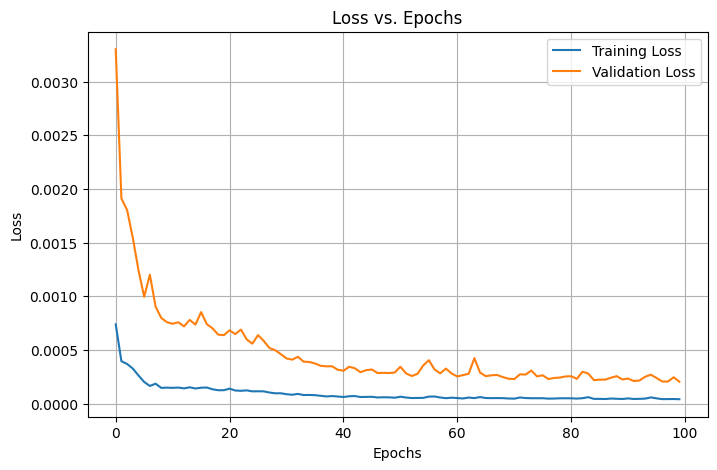

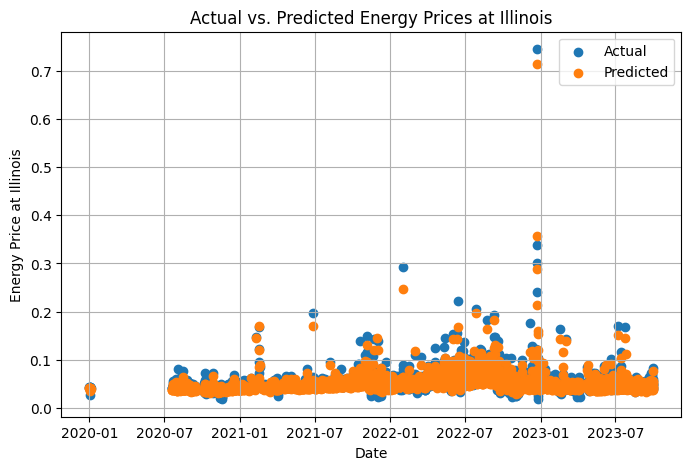

In [34]:
il_hub_data = energy_price_data[[
    'Date',
    'Sin_Month', 'Cos_Month', 'Sin_Day', 'Cos_Day','Sin_Hour', 'Cos_Hour',
    'Temperature',
    'Forecasted Load (MISO)',
    'Day Ahead Energy Price (IL)',
    'Energy Price (MICHIGAN.HUB)',
    'Energy Price (INDIANA.HUB)',
    'Energy Price (LOUISIANA.HUB)',
    'Energy Price (ARKANSAS.HUB)',
    'Energy Price (IL)'
    ]].drop_duplicates().reset_index(drop=True)
input_size = X_train_tensor.shape[2]
class RNN(nn.Module):
    """
    A simple RNN model for predicting the electric price in Illinois.

    model = RNN(input_size, hidden_size, num_layers) creates a RNN model.
    Parameters:
        input_size : int
            The number of features in the input. Needs to be 13.
        hidden_size : int
            The number of features in the hidden state of each RNN layers.
        num_layers : int
            The number of RNN layers.

    out = model(x) predicts the electric price in Illinois based on the input x.
    Inputs:
        x : torch.Tensor of shape (batch_size, 13, 1)
            The input is a time sequence of 13 features.
    Outputs:
        out : torch.Tensor of shape (batch_size, 1)
            The predicted electric price in Illinois.
    """
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:,-1,:])
        return out

class CustomDataset(Dataset):
    """
    A custom dataset class for loading the dataset.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def plot_prediction(predictions):
    """
    Plot the predicted electric price v.s. the acutal price at Illinois.
    """
    y_date = il_hub_data[['Date']]
    # y_date = y_date[y_date['Date'] >= '2023-06-01']

    plt.figure(figsize=(8, 5))
    ax = plt.axes()
    plt.scatter(X_test['Date'], y_test, label='Actual')
    plt.scatter(X_test['Date'], predictions, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Energy Price at Illinois')
    plt.title('Actual vs. Predicted Energy Prices at Illinois')
    # ax.set_xticks(['2023-06-01','2023-07-01','2023-08-01','2023-09-01','2023-10-01'])
    plt.legend()
    plt.grid(True)
    plt.show()

# hyperparameter
num_layers = 1          # The number of RNN layers
hidden_size = 32        # The number of features in the hidden state of each RNN layers

# Training loop
batch_size = 128
val_loader = DataLoader(CustomDataset(X_val_tensor,y_val_tensor), batch_size, shuffle=True)
train_loader = DataLoader(CustomDataset(X_train_tensor,y_train_tensor), batch_size, shuffle=True)
model = RNN(input_size, hidden_size, num_layers)
LossFunction = nn.MSELoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store the loss values
num_epochs = 100
train_loss_values = []
val_loss_values = []
test_loss_values = []

for epoch in range(num_epochs):
    loss_val = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = LossFunction(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
    train_loss_values.append(loss_val/X_train_tensor.shape[0])
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = LossFunction(y_pred, y_batch)
            optimizer.zero_grad()
            loss_val += loss.item()
        val_loss_values.append(loss_val/X_val_tensor.shape[0])
    
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_val/X_train_tensor.shape[0]:4.2e}")
        
print(f"Validation loss: {val_loss_values[-1]:4.2e}")


y_pred = model(X_test_tensor)
loss = LossFunction(y_pred, y_test_tensor)
print(f"Test loss: {loss.item():4.2e}")

# Plot the loss values
plt.figure(figsize=(8, 5))
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
# plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

plot_prediction(model(X_test_tensor).detach().numpy())


# num_epochs = 100
# for epoch in range(num_epochs):
#     loss_val = 0
#     for X_batch, y_batch in train_loader:
#         y_pred = model(X_batch)
#         loss = LossFunction(y_pred, y_batch)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         loss_val += loss.item()
#     if (epoch+1) % 10 == 0:
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_val/X_train_tensor.shape[0]:4.2e}")
# print(f"Validation loss: {nn.MSELoss()(model(X_val_tensor), y_val_tensor).item():4.2e}")
# plot_prediction(model(X_test_tensor).detach().numpy())

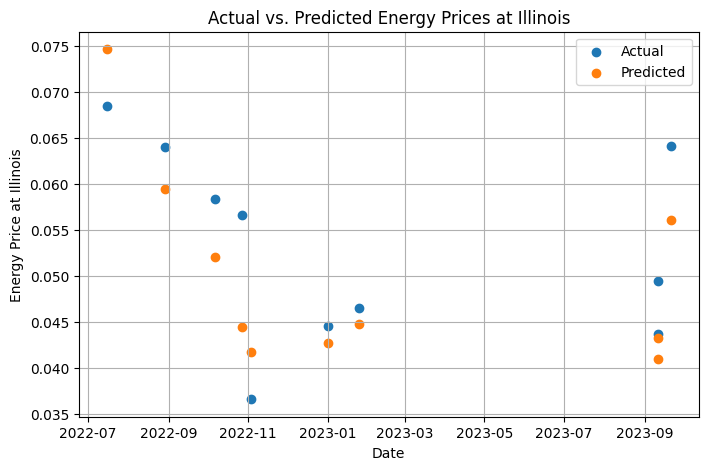

In [35]:

def plot_prediction_samples(predictions):
    """
    Plot the predicted electric price v.s. the acutal price at Illinois.
    """
    y_date = il_hub_data[['Date']]
    # y_date = y_date[y_date['Date'] >= '2023-06-01']

    plt.figure(figsize=(8, 5))
    ax = plt.axes()
    plt.scatter(X_test['Date'][:10], y_test[:10], label='Actual')
    plt.scatter(X_test['Date'][:10], predictions[:10], label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Energy Price at Illinois')
    plt.title('Actual vs. Predicted Energy Prices at Illinois')
    # ax.set_xticks(['2023-06-01','2023-07-01','2023-08-01','2023-09-01','2023-10-01'])
    plt.legend()
    plt.grid(True)
    plt.show()


plot_prediction_samples(model(X_test_tensor).detach().numpy())

In [36]:
import numpy as np

# Assuming y_test is the actual values and predictions are the predicted values
actual_values = y_test
predicted_values = model(X_test_tensor).detach().numpy()

# Calculate the absolute percentage error (APE)
ape = np.abs((actual_values - predicted_values.flatten()) / actual_values) * 100

# Calculate the percentage of data that falls within an error rate lower than 10%
percentage_within_10_percent_error = np.sum(ape < 10) / len(ape) * 100

print(f"{percentage_within_10_percent_error:.2f}% of the data falls within an error rate lower than 10%")

75.83% of the data falls within an error rate lower than 10%


**Feature importance**

We now peform feature importance for our RNN network. Recall that our dataset has 12 features

In [37]:
# hyperparameter
num_layers = 1          # The number of RNN layers
hidden_size = 32        # The number of features in the hidden state of each RNN layers

# Training loop
batch_size = 128
model = RNN(input_size, hidden_size, num_layers)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Train the original model
train_loader = DataLoader(CustomDataset(X_train_tensor, y_train_tensor), batch_size, shuffle=True)
for epoch in range(num_epochs):
    loss_val = 0
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_val += loss.item()

original_validation_loss = criterion(model(X_val_tensor), y_val_tensor).item()

# Feature importance
for i in range(il_hub_data.shape[1]):
    if il_hub_data.columns[i] in ['Date']:
        continue  # skip non-numerical features and target features
    X_train_tensor_feature_importance = X_train_tensor.clone()
    X_val_tensor_feature_importance = X_val_tensor.clone()
    X_test_tensor_feature_importance = X_test_tensor.clone()

    # discard the i-th feature
    X_train_tensor_feature_importance[:, i, :] = 0
    X_val_tensor_feature_importance[:, i, :] = 0
    X_test_tensor_feature_importance[:, i, :] = 0

    train_loader = DataLoader(CustomDataset(X_train_tensor_feature_importance, y_train_tensor), batch_size, shuffle=True)

    # train the model
    model_feature_importance = RNN(input_size, hidden_size, num_layers)
    optimizer_feature_importance = optim.Adam(model_feature_importance.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        loss_val = 0
        for X_batch, y_batch in train_loader:
            y_pred = model_feature_importance(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer_feature_importance.zero_grad()
            loss.backward()
            optimizer_feature_importance.step()
            loss_val += loss.item()

    # print the decrease of validation error
    validation_loss = criterion(model_feature_importance(X_val_tensor_feature_importance), y_val_tensor).item()
    print(f"Feature '{il_hub_data.columns[i]}': decrease in validation error = {original_validation_loss - validation_loss:4.2e}")

Feature 'Sin_Month': decrease in validation error = -7.69e-02
Feature 'Cos_Month': decrease in validation error = -2.82e-01
Feature 'Sin_Day': decrease in validation error = -2.32e-01
Feature 'Cos_Day': decrease in validation error = 6.97e-02
Feature 'Sin_Hour': decrease in validation error = -1.34e-01
Feature 'Cos_Hour': decrease in validation error = -1.96e-01
Feature 'Temperature': decrease in validation error = -4.40e-01
Feature 'Forecasted Load (MISO)': decrease in validation error = -2.67e-01
Feature 'Day Ahead Energy Price (IL)': decrease in validation error = -2.51e-01
Feature 'Energy Price (MICHIGAN.HUB)': decrease in validation error = -5.52e-01
Feature 'Energy Price (INDIANA.HUB)': decrease in validation error = -4.95e-01
Feature 'Energy Price (LOUISIANA.HUB)': decrease in validation error = -3.87e-01
Feature 'Energy Price (ARKANSAS.HUB)': decrease in validation error = 2.11e-02
Feature 'Energy Price (IL)': decrease in validation error = -7.01e-01


From the outcome above, we can conclude that the Energy price of Indiana is the most important feature.